In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from geopy import distance

In [229]:
df = pd.read_csv("all_cleaned.csv")
df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),A15541-1,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member
5,579D73BE2ED880B3,electric_bike,2022-07-01 17:04:35,2022-07-01 17:13:18,Desplaines St & Randolph St,15535,Clinton St & Roosevelt Rd,WL-008,41.884614,-87.644564,41.867118,-87.641088,member
6,EFE518CCEE333669,classic_bike,2022-07-18 18:11:01,2022-07-18 18:22:30,Marquette Ave & 89th St,20239,East End Ave & 87th St,20231,41.733669,-87.558342,41.736815,-87.582801,member
7,315FEBB7B3F6D2EA,classic_bike,2022-07-28 20:38:18,2022-07-28 21:09:11,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,casual
8,EE3C4A1E66766B56,classic_bike,2022-07-10 22:55:59,2022-07-10 23:01:32,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,member
9,1EE6C93A547A187C,electric_bike,2022-07-10 09:35:58,2022-07-10 09:47:25,Ashland Ave & Blackhawk St,13224,Orleans St & Merchandise Mart Plaza,TA1305000022,41.907093,-87.667247,41.888243,-87.636390,member


# Add columns for further use

## Ride distance

In [231]:
def calculate_distance(x):
    try:
        return distance.distance((x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).km
    except ValueError:
        return np.nan
    
        
df['distance'] = df.apply(lambda x: calculate_distance(x), axis=1)

## The length of the ride

In [233]:
df["started_at"] = pd.to_datetime(df["started_at"], errors='coerce')
df["ended_at"] = pd.to_datetime(df["ended_at"], errors='coerce')
df['ride_length'] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

## Check if it is a work day

In [234]:
national_holidays = [
    '2022-07-04',  # Independence Day
    '2022-09-05',  # Labor Day
    '2022-10-10',  # Columbus Day
    '2022-11-11',  # Veterans Day
    '2022-11-24',  # Thanksgiving Day
    '2022-12-25',  # Christmas Day
    '2023-01-01',  # New Year's Day
    '2023-01-16',  # Martin Luther King Jr. Day
    '2023-02-20',  # Presidents' Day
    '2023-05-29'   # Memorial Day
    ] 

df['day_of_week'] = df["started_at"].dt.dayofweek
df['is_holiday'] = df["started_at"].isin(national_holidays)
df['work_day'] = 1 - (df['is_holiday'] | (df['day_of_week'].isin([5, 6]))).astype(int)


## Check if it is rush_hour

In [236]:
df['rush_hour'] =  (((df['started_at'].dt.hour >= 7) & (df['started_at'].dt.hour <= 9)) | \
                             ((df['started_at'].dt.hour >= 16) & (df['started_at'].dt.hour <= 18)) & df['work_day']).astype(int)

# Analyze data

## Distance

In [250]:
df.groupby('member_casual').agg({'distance': ['mean', 'median'], 'ride_length': ['mean', 'median'], 'work_day': ['count']})

distance           ride_length            work_day
                   mean    median        mean     median    count
member_casual                                                    
casual         2.205814  1.684853   28.358464  13.516667   711160
member         2.234374  1.649351   13.470330   9.750000   783682

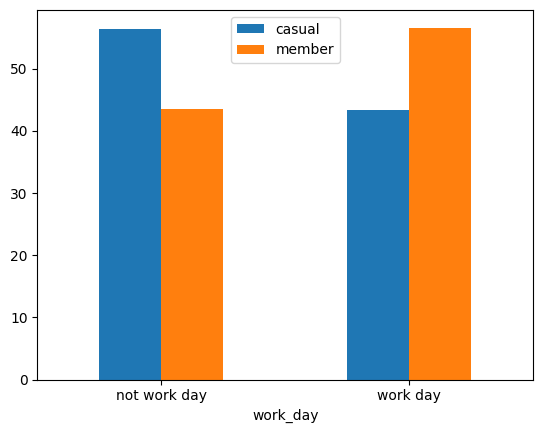

In [255]:
work_day = df.groupby(['work_day', 'member_casual']).size() / df.groupby('work_day').size() * 100
ax = work_day.unstack('member_casual').plot.bar()
ax.set_xticklabels(["not work day","work day"], rotation=0) 
ax.legend(loc=9)

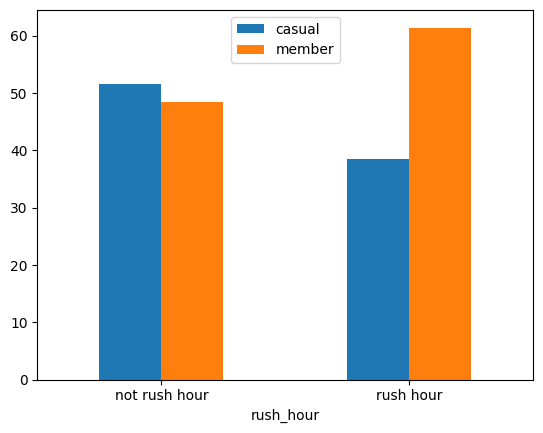

In [254]:
rush_hour = df.groupby(['rush_hour', 'member_casual']).size() / df.groupby('rush_hour').size() * 100
ax = rush_hour.unstack('member_casual').plot.bar()
ax.set_xticklabels(['not rush hour', 'rush hour'], rotation=0)
ax.legend(loc=9)


array([<AxesSubplot:title={'center':'casual'}>,
       <AxesSubplot:title={'center':'member'}>], dtype=object)

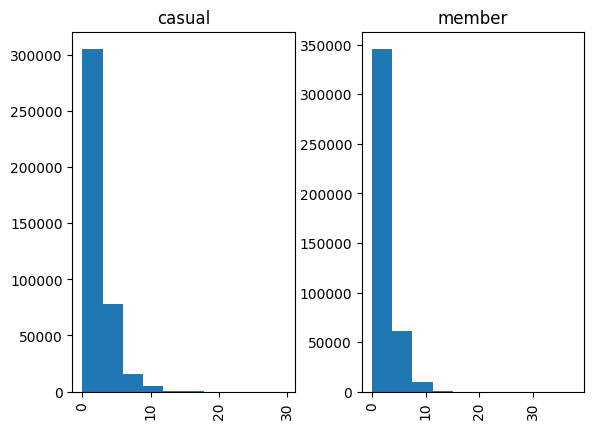

In [66]:
df.hist('distance', by='member_casual')

In [209]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,ride_duration,day_of_week,is_holiday,weekend_holiday,rush_hour
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member,3.104577,11.750000,1,False,0,1
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual,0.350123,1.883333,1,False,0,0
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual,0.350123,7.716667,6,False,1,0
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),15541,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual,8.569135,58.483333,6,False,1,1
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member,5.418878,26.300000,2,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823483,605787F70B3B9FD3,electric_bike,2022-07-09 08:32:15,2022-07-09 08:56:10,NaN,NaN,NaN,NaN,41.740000,-87.680000,41.750000,-87.680000,member,1.110683,23.916667,5,False,1,1
823484,F0EECBEE637DF028,electric_bike,2022-07-17 13:27:57,2022-07-17 13:33:09,NaN,NaN,NaN,NaN,41.870000,-87.660000,41.870000,-87.680000,member,1.660384,5.200000,6,False,1,0
823485,B8B091DC72DDAB9D,electric_bike,2022-07-17 14:51:37,2022-07-17 14:57:01,NaN,NaN,NaN,NaN,41.950000,-87.640000,41.950000,-87.650000,member,0.829156,5.400000,6,False,1,0
823486,B4D3FFCC1F3AF5EC,electric_bike,2022-07-28 13:41:50,2022-07-28 13:47:17,NaN,NaN,NaN,NaN,41.880000,-87.630000,41.870000,-87.630000,member,1.110709,5.450000,3,False,0,0


In [213]:
df.groupby(['rideable_type', 'member_casual']).size()

rideable_type  member_casual
classic_bike   casual           156095
               member           217078
docked_bike    casual            31055
electric_bike  casual           218905
               member           200355
dtype: int64

In [214]:
df['ride_id'].nunique()

823488

In [79]:
df1['ride_duration'] = df1['ride_duration'].dt.total_seconds() / 60

In [80]:
df1.loc[0, 'ride_duration']

11.75

In [90]:
df.groupby('member_casual')['ride_duration'].mean()

member_casual
casual   0 days 00:29:16.685269236
member   0 days 00:13:43.100408927
Name: ride_duration, dtype: timedelta64[ns]

In [91]:
df['member_casual'].value_counts()

member    417433
casual    406055
Name: member_casual, dtype: int64

In [98]:
df.groupby('member_casual')['weekend'].value_counts()

member_casual  weekend
casual         0          232574
               1          173481
member         0          289784
               1          127649
Name: weekend, dtype: int64

In [99]:
23/41

0.5609756097560976

In [100]:
28/40

0.7

In [104]:
df.groupby(['member_casual', 'weekend']).size() / df.groupby('member_casual').size() * 100

member_casual  weekend
casual         0          57.276477
               1          42.723523
member         0          69.420482
               1          30.579518
dtype: float64

In [110]:
df.groupby(['start_station_id', 'member_casual']).size()

start_station_id  member_casual
021320            casual             21
                  member             48
1011              casual             25
                  member             16
1012              casual              5
                                   ... 
chargingstx3      member           1045
chargingstx4      casual              5
                  member              2
chargingstx5      casual            527
                  member            774
Length: 2117, dtype: int64

In [145]:
result = df.groupby('start_station_id')['member_casual'].agg(
    Count='size',
    Percentage_Member=lambda x: (x == 'member').sum() / len(x) * 100
)
result_drop_no_use = result[result['Count']>=150]

In [174]:
stations_most_used = result_drop_no_use.sort_values(by='Count', ascending=False)[:100]
stations_most_used_by_member = result_drop_no_use.sort_values(by='Percentage_Member', ascending=False)[:100]

In [165]:
stations_most_used_by_member.sort_values(by='Count')

,Count,Percentage_Member
start_station_id,,
KA1503000075,152,58.552632
314,154,38.311688
312,156,67.948718
15470,159,48.427673
432,159,32.075472
...,...,...
TA1308000001,6988,39.324556
13300,7833,21.434955
13042,7975,30.934169


In [166]:
stations_most_used

,Count,Percentage_Member
start_station_id,,
13022,14808,20.353863
LF-005,8753,36.318976
13042,7975,30.934169
13300,7833,21.434955
TA1308000001,6988,39.324556
...,...,...
432,159,32.075472
15470,159,48.427673
312,156,67.948718


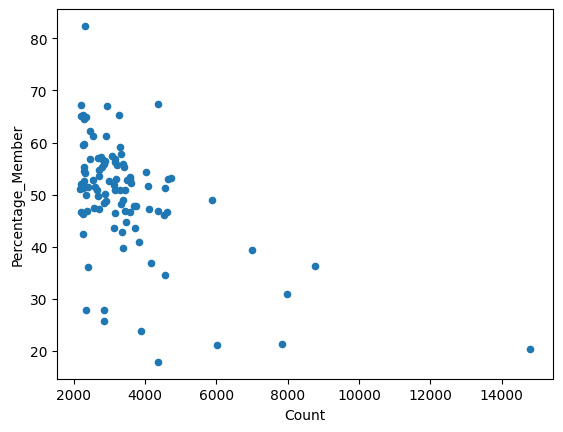

In [175]:
ax = stations_most_used.plot.scatter('Count', 'Percentage_Member')


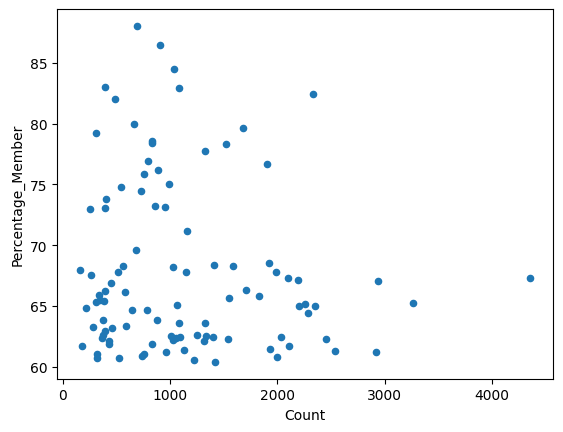

In [176]:
ax1 = stations_most_used_by_member.plot.scatter('Count', 'Percentage_Member')

In [177]:
len(stations_most_used_by_member.index.intersection(stations_most_used.index))

12

In [179]:
df.loc[0, "started_at"] == '2022-07-05'

False

In [237]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,ride_length,day_of_week,is_holiday,work_day,rush_hour
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member,3.104577,11.750000,1,False,1,1
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual,0.350123,1.883333,1,False,1,0
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual,0.350123,7.716667,6,False,0,0
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),A15541-1,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual,8.569135,58.483333,6,False,0,0
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member,5.418878,26.300000,2,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494837,2DF79AA3C3B5871E,electric_bike,2022-08-12 17:45:24,2022-08-12 17:54:28,Elston Ave & Cortland St,TA1305000039,Clark St & Armitage Ave,13146,41.916454,-87.666852,41.918306,-87.636282,casual,2.544367,9.066667,4,False,1,1
1494838,823E631AB2F2F2E5,electric_bike,2022-08-29 21:34:10,2022-08-29 22:08:55,St. Louis Ave & Balmoral Ave,KA1504000161,Halsted St & Roscoe St,TA1309000025,41.980356,-87.716142,41.943670,-87.648950,casual,6.901593,34.750000,0,False,1,0
1494839,0DACCC2AE61AF69B,electric_bike,2022-08-30 06:51:48,2022-08-30 06:56:04,Clinton St & Jackson Blvd,A638-1,Aberdeen St & Jackson Blvd,13157,41.878339,-87.641321,41.877726,-87.654787,casual,1.119875,4.266667,1,False,1,0
1494840,F7D0723B109B03D4,electric_bike,2022-08-19 20:52:26,2022-08-19 22:00:27,Dearborn St & Erie St,13045,Rush St & Hubbard St,KA1503000044,41.894206,-87.629336,41.890173,-87.626185,casual,0.518687,68.016667,4,False,1,0
